## Overview

The goal of this notebook is to illustrate and compare different LCP solutions to Ben Moll's [vanilla example](http://www.princeton.edu/~moll/HACTproject/option_simple.pdf).

Here is a summary of the methods tried and relevant information.

| Method | Successful? | Time | 
|--------|----------|--------|
| `PATHSolver.jl` | Yes | 4e-6 seconds (`1e-12` tolerance, second run) |
| `Complementarity.jl` | No (JuMP) | N/A (Note: Calls to `PATHSolver` for solution) | 
| `NLsolve.jl` | Yes | 60e-6 seconds (`ftol = 1e-12`, second run) | 
| `VariationalInequality.jl` | No (JuMP) | N/A | 
| `JuMP` + Ipopt | Yes | 55e-6 seconds | 

#### Setup

Let's pull parameters from the [MATLAB code](https://github.com/econtoolkit/continuous_time_methods/blob/master/matlab/tests/simple_optimal_stopping_diffusion_test.m).

In [1]:
using Parameters, LinearAlgebra

StoppingProblem = @with_kw (μ_bar = -0.01, 
                            σ_bar = 0.01, 
                            S_bar = 10.0, 
                            γ = 0.5, # u(x) = x^γ
                            ρ = 0.05, # discount rate
                            x_min = 0.01,
                            x_max = 1.0,
                            M = 1000) # num of grid points 

#3 (generic function with 2 methods)

Let's also copy the discretization method from [PTW](https://github.com/jlperla/PerlaTonettiWaugh.jl/commits/master/src/utils/diffusionoperators.jl). This is for a reflecting barrier at each boundary.

In [2]:
# Diffusion operators with regular grids
function diffusionoperators(x::AbstractRange; ξ = 0.0) # ξ = 0.0 corresponds to the unrescaled case from PTW
    Δ = step(x)
    P = length(x)

    dl_1 = zeros(P-1)
    d_1 = -ones(P)
    du_1 = ones(P-1)
    d_1[end] = d_1[end] + du_1[end] * (1-ξ*Δ)
    L_1_plus = Tridiagonal(dl_1, d_1, du_1)/Δ

    dl_m1 = -ones(P-1)
    d_m1 = ones(P)
    du_m1 = zeros(P-1)
    d_m1[1] = d_m1[1] + dl_m1[1] * (1+ξ*Δ)
    L_1_minus = Tridiagonal(dl_m1, d_m1, du_m1)/Δ

    dl_2 = ones(P-1)
    d_2 = -2 * ones(P)
    d_2[1] = -2 + (1+ξ*Δ)
    d_2[end] = -2 + (1-ξ*Δ)
    du_2 = ones(P-1)
    L_2 = Tridiagonal(dl_2, d_2, du_2)/(Δ^2)

    return (x, L_1_minus, L_1_plus, L_2)
end

diffusionoperators (generic function with 1 method)

### Approach 1: Simplest LCP with PATHSolver.jl
-------

Here, we consider the case with constrant drift $\mu(x) = \bar{\mu}$, stopping value $S(x) \equiv \bar{S}$, and variance $\sigma(x) = \bar{\sigma}$.

First, here's a function to take model parameters and return LCP objects.

In [3]:
function LCP_objects(sp)
    # setup work 
    @unpack μ_bar, σ_bar, S_bar, γ, ρ, x_min, x_max, M = sp 
    grid = range(x_min, x_max, length = M)
    tmp, L_1_minus, L_1_plus, L_2 = diffusionoperators(grid) 
    μ = μ_bar 
    S = x -> S_bar 
    u = x -> x^γ # L36 from MATLAB
    σ = σ_bar 
    # construct objects
    A = μ * L_1_minus + 1/2 * σ^2 * L_2 # stochastic generator. use L_1_minus because drift is always negative
    B = ρ*I - A 
    S_vec = S.(grid)
    -u.(grid)
    q_vec = -u.(grid) + B*S_vec
    # return 
    return (A = A, B = B, S = S_vec, q = q_vec)
end

LCP_objects (generic function with 1 method)

Let's generate these objects for the default case.

In [4]:
sp = StoppingProblem()
@unpack A, B, S, q = LCP_objects(sp);

This suggests the following linear complementarity problem:

$$ 
\begin{align}
z'(\mathbf{B}z + q) &= 0 \\ 
z &\geq 0 \\ 
\mathbf{B}z + q &\geq 0
\end{align}
$$

Let's give it to PATHSolver.

In [5]:
using PATHSolver

In [6]:
f = z -> B*z + q
n = sp.M
lb = zeros(n)
ub = 1000*ones(n) # a reasonable guess?
options(convergence_tolerance = 1e-12, output = :no, time_limit = 600) # 10 minute budget
@time exit_code, sol_z, sol_f = solveLCP(f, lb, ub)

  1.377233 seconds (3.40 M allocations: 197.704 MiB, 4.10% gc time)
Reading options file path.opt
 > convergence_tolerance 1.0e-12
Read of options file complete.

1000 row/cols, 2998 non-zeros, 0.30% dense.

Path 4.7.03 (Thu Jan 24 15:44:12 2013)
Written by Todd Munson, Steven Dirkse, and Michael Ferris

 ** EXIT - other error.


(:StationaryPointFound, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  7.6867, 7.69559, 7.70406, 7.71202, 7.71937, 7.72598, 7.73171, 7.73638, 7.73977, 7.74162], [0.4, 0.395162, 0.390538, 0.386101, 0.381831, 0.37771, 0.373723, 0.369858, 0.366105, 0.362454  …  -3.58602e-14, 1.84297e-14, -7.07212e-14, 2.39808e-14, -3.58602e-14, 5.09592e-14, 8.43769e-14, -1.4877e-14, 7.63833e-14, 5.68434e-14])

In [7]:
exit_code # this lets us handle logic like converged(exit_code) || error("foobar")

:StationaryPointFound

Now, we can unpack the solutions and plot them.

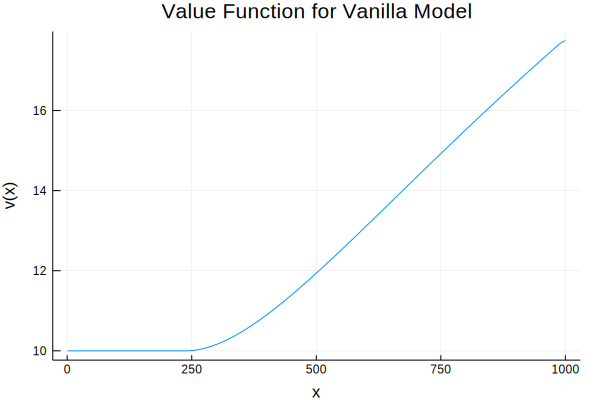

In [8]:
using Plots
v = sol_z + S 
plot(v, title = "Value Function for Vanilla Model", legend = false, xlabel = "x", ylabel = "v(x)")

This is the kind of thing we expect --- below some threshold you get the stopping value $S \equiv 10$, and above it you get a smoothly increasing value.

**Note:** `PATHSolver.jl` is the backend used by `Complementarity.jl`, so there's no need to test that package separately (and, in fact, I couldn't get the macro/JuMP setup to work.)

### Approach 2: Same Problem with NLsolve
------

In [9]:
using NLsolve

┌ Info: Recompiling stale cache file /Users/Jozefiak/.julia/compiled/v1.1/NLsolve/KFCNP.ji for NLsolve [2774e3e8-f4cf-5e23-947b-6d7e65073b56]
└ @ Base loading.jl:1184


In [10]:
function f!(F, z)
    F .= B*z + q # in place assignment
end

f! (generic function with 1 method)

In [11]:
@time r = mcpsolve(f!, lb, ub,
                zeros(n), # initial condition
                reformulation = :smooth, # uses a so-called "Fischer function" to smooth out the problem
                autodiff = :forward,
                ftol = 1e-12);

  5.725109 seconds (12.87 M allocations: 1.253 GiB, 9.23% gc time)


As before, we can plot the resulting value function.

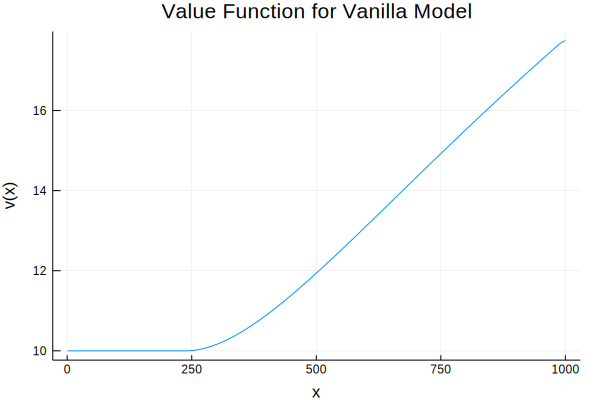

In [12]:
v = r.zero + S 
plot(v, title = "Value Function for Vanilla Model", legend = false, xlabel = "x", ylabel = "v(x)")

Reassuringly, they look about the same.

### Approach 3: JuMP
--------

In [13]:
using JuMP, Ipopt

In [14]:
#m = Model(solver=IpoptSolver(tol=1e-12))
m = Model(with_optimizer(Ipopt.Optimizer, tol=1e-12))


A JuMP Model
Feasibility problem with:
Variables: 0
Model mode: AUTOMATIC
CachingOptimizer state: EMPTY_OPTIMIZER
Solver name: SolverName() attribute not implemented by the optimizer.

In [15]:
@variable(m, z[1:sp.M])

1000-element Array{VariableRef,1}:
 z[1]   
 z[2]   
 z[3]   
 z[4]   
 z[5]   
 z[6]   
 z[7]   
 z[8]   
 z[9]   
 z[10]  
 z[11]  
 z[12]  
 z[13]  
 ⋮      
 z[989] 
 z[990] 
 z[991] 
 z[992] 
 z[993] 
 z[994] 
 z[995] 
 z[996] 
 z[997] 
 z[998] 
 z[999] 
 z[1000]

In [16]:
@constraint(m, z .>= 0) # first nonnegativity constraint

1000-element Array{ConstraintRef{Model,MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64},MathOptInterface.GreaterThan{Float64}},ScalarShape},1}:
 z[1] ≥ 0.0   
 z[2] ≥ 0.0   
 z[3] ≥ 0.0   
 z[4] ≥ 0.0   
 z[5] ≥ 0.0   
 z[6] ≥ 0.0   
 z[7] ≥ 0.0   
 z[8] ≥ 0.0   
 z[9] ≥ 0.0   
 z[10] ≥ 0.0  
 z[11] ≥ 0.0  
 z[12] ≥ 0.0  
 z[13] ≥ 0.0  
 ⋮            
 z[989] ≥ 0.0 
 z[990] ≥ 0.0 
 z[991] ≥ 0.0 
 z[992] ≥ 0.0 
 z[993] ≥ 0.0 
 z[994] ≥ 0.0 
 z[995] ≥ 0.0 
 z[996] ≥ 0.0 
 z[997] ≥ 0.0 
 z[998] ≥ 0.0 
 z[999] ≥ 0.0 
 z[1000] ≥ 0.0

In [17]:
@constraint(m, B*z + q .>= 0) # second nonlinearity complaint

1000-element Array{ConstraintRef{Model,MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64},MathOptInterface.GreaterThan{Float64}},ScalarShape},1}:
 50.963223140495856 z[1] - 50.91322314049586 z[2] ≥ -0.4                                                
 -61.00413223140495 z[1] + 111.96735537190081 z[2] - 50.91322314049586 z[3] ≥ -0.3951620727457512       
 -61.00413223140495 z[2] + 111.96735537190081 z[3] - 50.91322314049586 z[4] ≥ -0.39053776001763396      
 -61.00413223140495 z[3] + 111.96735537190081 z[4] - 50.91322314049586 z[5] ≥ -0.3861010405098138       
 -61.00413223140495 z[4] + 111.96735537190081 z[5] - 50.91322314049586 z[6] ≥ -0.3818307825026454       
 -61.00413223140495 z[5] + 111.96735537190081 z[6] - 50.91322314049586 z[7] ≥ -0.3777095467547562       
 -61.00413223140495 z[6] + 111.96735537190081 z[7] - 50.91322314049586 z[8] ≥ -0.37372274177066866      
 -61.00413223140495 z[7] + 111.96735537190081 z[8] - 50.91322314049586 z[9] ≥ -0.369858012

In [18]:
@objective(m, Min, z' * B * z + z' * q); # objective for problem

In [19]:
#@time res = solve(m);
@time res = optimize!(m);


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     3998
Number of nonzeros in Lagrangian Hessian.............:     1999

Total number of variables............................:     1000
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equ

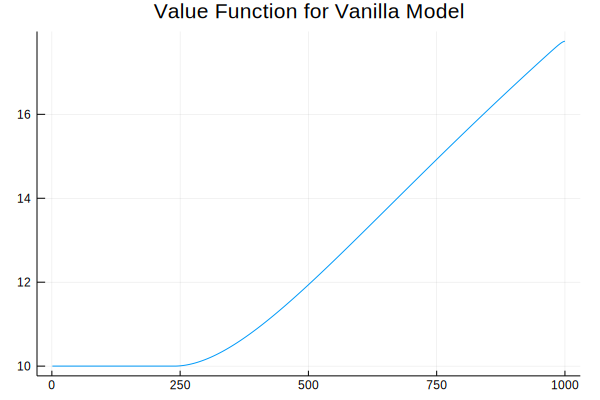

In [20]:
#plot(getvalue(z) + S, legend = false, title = "Value Function for Vanilla Model")
plot(value.(z) + S, legend = false, title = "Value Function for Vanilla Model")


### Benchmarking (including commercial)
------

In [21]:
using Suppressor

In [22]:
function LCP_1()
    sp = StoppingProblem()
    @unpack A, B, S, q = LCP_objects(sp)
    f = z -> B*z + q
    n = sp.M
    lb = zeros(n)
    ub = 1000*ones(n) # a reasonable guess?
    @suppress options(convergence_tolerance = 1e-9, output = :no, time_limit = 600) # 10 minute budget
    @suppress solveLCP(f, lb, ub);
end

LCP_1 (generic function with 1 method)

In [23]:
function LCP_2()
    sp = StoppingProblem()
    @unpack A, B, S, q = LCP_objects(sp)
    f = z -> B*z + q
    n = sp.M
    lb = zeros(n)
    ub = 1000*ones(n) # a reasonable guess?
    function f!(F, z)
        F .= B*z + q # in place assignment
    end
    @suppress mcpsolve(f!, lb, ub,
                zeros(n), # initial condition
                reformulation = :smooth, # uses a so-called "Fischer function" to smooth out the problem
                autodiff = :forward,
                ftol = 1e-9)
end

LCP_2 (generic function with 1 method)

In [24]:
function LCP_3()
    sp = StoppingProblem()
    @unpack A, B, S, q = LCP_objects(sp)
    f = z -> B*z + q 
    n = sp.M
    #m = Model(solver = IpoptSolver(tol=1e-9))
    m = Model(with_optimizer(Ipopt.Optimizer, tol=1e-9))
    @variable(m, z[1:n])
    @constraint(m, z .>= 0)
    @constraint(m, B*z + q .>= 0)
    @objective(m, Min, z' * B * z + z' * q)
    #@suppress solve(m);
    @suppress optimize!(m);
end

LCP_3 (generic function with 1 method)

In [25]:
using Gurobi, Mosek, OSQP, MathOptInterfaceMosek

┌ Info: Recompiling stale cache file /Users/Jozefiak/.julia/compiled/v1.1/Mosek/vS2ln.ji for Mosek [6405355b-0ac2-5fba-af84-adbd65488c0e]
└ @ Base loading.jl:1184
┌ Info: Recompiling stale cache file /Users/Jozefiak/.julia/compiled/v1.1/MathOptInterfaceMosek/sqIeN.ji for MathOptInterfaceMosek [0087ddc6-3964-5e57-817f-9937aefb0357]
└ @ Base loading.jl:1184


In [26]:
function LCP_4()
    sp = StoppingProblem()
    @unpack A, B, S, q = LCP_objects(sp)
    f = z -> B*z + q 
    n = sp.M
    #m = Model(solver = GurobiSolver())
    m = Model(with_optimizer(Gurobi.Optimizer))
    @variable(m, z[1:n])
    @constraint(m, z .>= 0)
    @constraint(m, B*z + q .>= 0)
    @objective(m, Min, z' * B * z + z' * q)
    #@suppress solve(m);
    @suppress optimize!(m);
end

LCP_4 (generic function with 1 method)

In [27]:
function LCP_5()
    sp = StoppingProblem()
    @unpack A, B, S, q = LCP_objects(sp)
    f = z -> B*z + q 
    n = sp.M
    #m = Model(solver = MosekSolver(MSK_DPAR_BASIS_TOL_X=1e-9))
    m = Model(with_optimizer(MosekOptimizer, MSK_DPAR_BASIS_TOL_X=1e-9))
    @variable(m, z[1:n])
    @constraint(m, z .>= 0)
    @constraint(m, B*z + q .>= 0)
    @objective(m, Min, z' * B * z + z' * q)
    #@suppress solve(m);
    @suppress optimize!(m);
end

LCP_5 (generic function with 1 method)

In [28]:
function LCP_6()
    sp = StoppingProblem()
    @unpack A, B, S, q = LCP_objects(sp)
    f = z -> B*z + q 
    n = sp.M
    #m = Model(solver = OSQPMathProgBaseInterface.OSQPSolver(tol=1e-9))
    m = Model(with_optimizer(OSQP.MathOptInterfaceOSQP.Optimizer))
    @variable(m, z[1:n])
    @constraint(m, z .>= 0)
    @constraint(m, B*z + q .>= 0)
    @objective(m, Min, z' * B * z + z' * q)
    #@suppress solve(m);
    @suppress optimize!(m)
end

LCP_6 (generic function with 1 method)

In [29]:
using BenchmarkTools
@btime LCP_1();

  16.726 ms (989 allocations: 25.29 MiB)


In [30]:
@btime LCP_2();

  609.998 ms (34321 allocations: 634.90 MiB)


In [31]:
@btime LCP_3();

  231.883 ms (245017 allocations: 13.61 MiB)


In [32]:
# This was not in the notebook originally
#@btime LCP_4(); 

In [33]:
@btime LCP_5();

ErrorException: The solver does not support an objective function of type MathOptInterface.ScalarQuadraticFunction{Float64}.

In [34]:
@btime LCP_6();

  184.438 ms (261042 allocations: 15.51 MiB)
